# Understanding Stress Through Sleep Patterns 
by Yuheng Ouyang, Eduardo Rivera, Harpreet Singh, Songyang Yu 2025/12/7

## 1. Summary

In this project, we explore how an individual’s sleep wellness relates to their reported stress level using the Sleep Health and Lifestyle Dataset. Our goal is to investigate whether sleep patterns can help explain or predict how stressed a person feels. To do this, we perform exploratory data analysis to understand trends in the data and examine whether shorter or irregular sleep is associated with higher stress. We then build a predictive model to evaluate how well sleep duration and related lifestyle variables can estimate a person’s stress level. This analysis aims to provide insight into the connection between sleep habits and stress, and to identify whether simple, easily measurable lifestyle information can meaningfully contribute to stress assessment.

Our study corroborates these findings by showing that sleep duration and quality are inversely related to self-reported stress levels. With the $R^2$ score of 0.51, and the residual plot suggests of non-linear relations between sleep duration, quality and stress levels.

## 2. Introduction

Stress is a major public health concern, there are surveys consistently report that more than 1/3 of adults experience high stress on a regular basis (Sleep Foundation, 2025). Chronic stress has been linked to anxiety, cardiovascular disease, weakened immunity, and reduced productivity. At the same time, insufficient sleep is extremely common—recent population studies suggest that about 30 % of adults sleep fewer than the recommended 7 hours per night (Centers for Disease Control and Prevention [CDC], 2024). Because sleep plays a crucial role in emotional regulation, cognitive performance, and physical recovery, disruptions in sleep duration are believed to contribute directly to increased stress levels.

In this project, we ask whether information about a person’s sleep duration and daily lifestyle habits can help explain or predict their self-reported stress level. This question is important because stress assessments typically rely on subjective questionnaires or clinical evaluations, which can vary among individuals and are difficult to scale. If simple, easy-to-measure variables—such as how long someone sleeps or how active they are during the day—can provide meaningful insight into stress, this could support early identification of at-risk individuals and inform recommendations for healthier sleep and lifestyle patterns.

To explore this question, we analyze the Sleep Health and Lifestyle Dataset (Varishabatool, n.d.), which contains information on individuals’ sleep duration, sleep quality, physical activity, demographic attributes, and self-reported stress. This dataset allows us to examine behavioral patterns related to sleep, identify lifestyle factors that correlate with stress, and evaluate whether a predictive model can estimate stress levels using accessible and non-clinical lifestyle data.

## 3. Methods

### 3.1. Imports

In [1]:
# Data wrangling libraries
import numpy as np
import pandas as pd
from scipy.stats import linregress, gaussian_kde

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data validation libraries
import pandera as pa
from pandera import Column, Check
from deepchecks.tabular.checks import FeatureLabelCorrelation, FeatureFeatureCorrelation
from deepchecks.tabular import Dataset

### 3.2. Data Loading and Preprocessing

The Sleep Health and Lifestyle Dataset is publicly released on [Kaggle](https://www.kaggle.com/datasets/varishabatool/disorder) under [CC0](https://creativecommons.org/publicdomain/zero/1.0/) license. We use one of its [GitHub mirror](https://raw.githubusercontent.com/Muhanad-husn/Sleep-Health-and-Lifestyle/main/data.csv) (Husn, 2023) in our analysis to avoid Kaggle authentication.

In [2]:
url = "https://raw.githubusercontent.com/Muhanad-husn/Sleep-Health-and-Lifestyle/main/data.csv"
df = pd.read_csv(url)

In [3]:
print(df.shape)
df.head()

(374, 13)


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


**Table 1:** First five rows of the Sleep Health & Lifestyle dataset

The dataset has 374 records and 12 features [excluding the `Person ID`]. In our analysis, we evaluate the relationships between stress level and three features about sleep wellness. The first feature is `Sleep Duration`, a numerical/continuous variable representing hours of sleep per night. The second is `Quality of Sleep`, a numerical/ordinal measure of self-reported quality of sleep. The third is `Sleep Disorder`, a categorical variable indicating diagnosed sleep disorder (None, Insomnia, or Sleep Apnea). The target column `Stress Level` is the level of stress assessed through interviews or questionnaires. The values range from 3 (minimum) to 8 (maximum). Our model will predict the stress level as numeric scores through the input features.

To prepare the data for analysis, we first drop the unused columns. <span style='color:steelblue'>[NOTE: we are keeping the `Person ID` for now and will be dropped before the analysis]</span>

In [4]:
df_clean = df.copy()
df_clean = df_clean[[
    "Person ID",
    "Sleep Duration",
    "Quality of Sleep",
    "Sleep Disorder",
    "Stress Level"
]]

# renaming columns using the camel_syntax
name_conversion_dict = {
    "Person ID": 'person_id',
    "Sleep Duration": 'sleep_duration',
    "Quality of Sleep": 'sleep_quality',
    "Sleep Disorder": 'sleep_disorder',
    "Stress Level": 'stress_level'
}

df_clean = df_clean.rename(columns=name_conversion_dict)

df_clean.sample(7).reset_index(drop=True)

,person_id,sleep_duration,sleep_quality,sleep_disorder,stress_level
0,280,8.3,9,NaN,3
1,290,6.1,6,Sleep Apnea,8
2,213,7.8,8,NaN,5
3,15,6.0,6,NaN,8
4,340,8.1,9,Sleep Apnea,4
5,324,8.5,9,NaN,3
6,259,6.6,7,Insomnia,4


The `NaN` values in the `Sleep Disorder` column means the individual has not been diagnosed with a sleep disorder. We replace the `NaN` values with a string value `No Disorder`.

In [5]:
df_clean[["sleep_disorder"]] = df_clean[["sleep_disorder"]].fillna("No Disorder")
df_clean.sample(7).reset_index(drop=True)

,person_id,sleep_duration,sleep_quality,sleep_disorder,stress_level
0,366,8.0,9,Sleep Apnea,3
1,256,6.5,7,Insomnia,4
2,72,6.1,6,No Disorder,8
3,7,6.3,6,Insomnia,7
4,117,7.2,8,No Disorder,4
5,335,8.4,9,No Disorder,3
6,98,7.1,8,No Disorder,4


We retain local copies of the original and preprocessed data. 

In [6]:
# df.to_csv('data/raw/sleep_data_raw.csv')
# df_clean.to_csv('data/processed/sleep_data_clean.csv')

### 3.3. Data Spltting

The data is splitinto train (80%) and test (20%) sets. The train set contains 299 records. 

In [7]:
train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=522)
train_df.shape

(299, 5)

In [8]:
train_df.drop(columns=['person_id']).describe(include="all")

,sleep_duration,sleep_quality,sleep_disorder,stress_level
count,299.000000,299.000000,299,299.000000
unique,NaN,NaN,3,NaN
top,NaN,NaN,No Disorder,NaN
freq,NaN,NaN,176,NaN
mean,7.123411,7.324415,NaN,5.377926
std,0.802421,1.217231,NaN,1.813719
min,5.800000,4.000000,NaN,3.000000
25%,6.400000,6.000000,NaN,4.000000
50%,7.200000,7.000000,NaN,5.000000
75%,7.800000,8.000000,NaN,7.000000


**Table 2:** Descriptive statistics of the training dataset

## 4. Results

### 4.1 Data Validation

Before we proceed with the data, we will perform a quality checks on the data ensuring the quality of the data is to the standard.

In [9]:
sleep_schema = pa.DataFrameSchema(
    {
        "sleep_disorder": Column(str, Check.isin(["No Disorder", "Sleep Apnea", "Insomnia"]), nullable=False),
        "sleep_duration": Column(float, Check.between(3, 12), nullable=False),
        "sleep_quality": Column(int, Check.between(1, 10), nullable=False),
        "stress_level": Column(int, Check.between(1, 10), nullable=False),
    },
    checks=[
        Check(lambda df: ~df.duplicated().any(), error="Duplicate rows found."),
        Check(lambda df: ~(df.isna().all(axis=1)).any(), error="Empty rows (all-NA) found."),
    ],
)

try:
    sleep_schema.validate(train_df, lazy=True)
    print('Training data validation passed!')
except pa.errors.SchemaErrors as exc:
    print("Warning: Test data schema violations:")
    print(exc)

Training data validation passed!


Before running the model, we perform a quality check on the test data to ensure it meets the expected format and minimum quality thresholds. This validation uses a predefined schema and does not involve any data exploration or transformations that would violate the golden rule.

In [10]:
try:
    sleep_schema.validate(test_df, lazy=True)
    print("Test data validation passed!")
except pa.errors.SchemaErrors as exc:
    print("Warning: Test data schema violations:")
    print(exc)

Test data validation passed!


After the quality checks are done, we will now drop the `Person ID` colmn.

In [11]:
train_df.set_index('person_id', inplace=True)
test_df.set_index('person_id', inplace=True)

In [12]:
train_df.head()

,sleep_duration,sleep_quality,sleep_disorder,stress_level
person_id,,,,
63,6.2,6,No Disorder,8
139,7.1,8,No Disorder,4
74,6.1,6,No Disorder,8
60,7.7,7,No Disorder,6
275,6.2,6,Sleep Apnea,8


### 4.2 Exploratory Data Analysis (EDA)

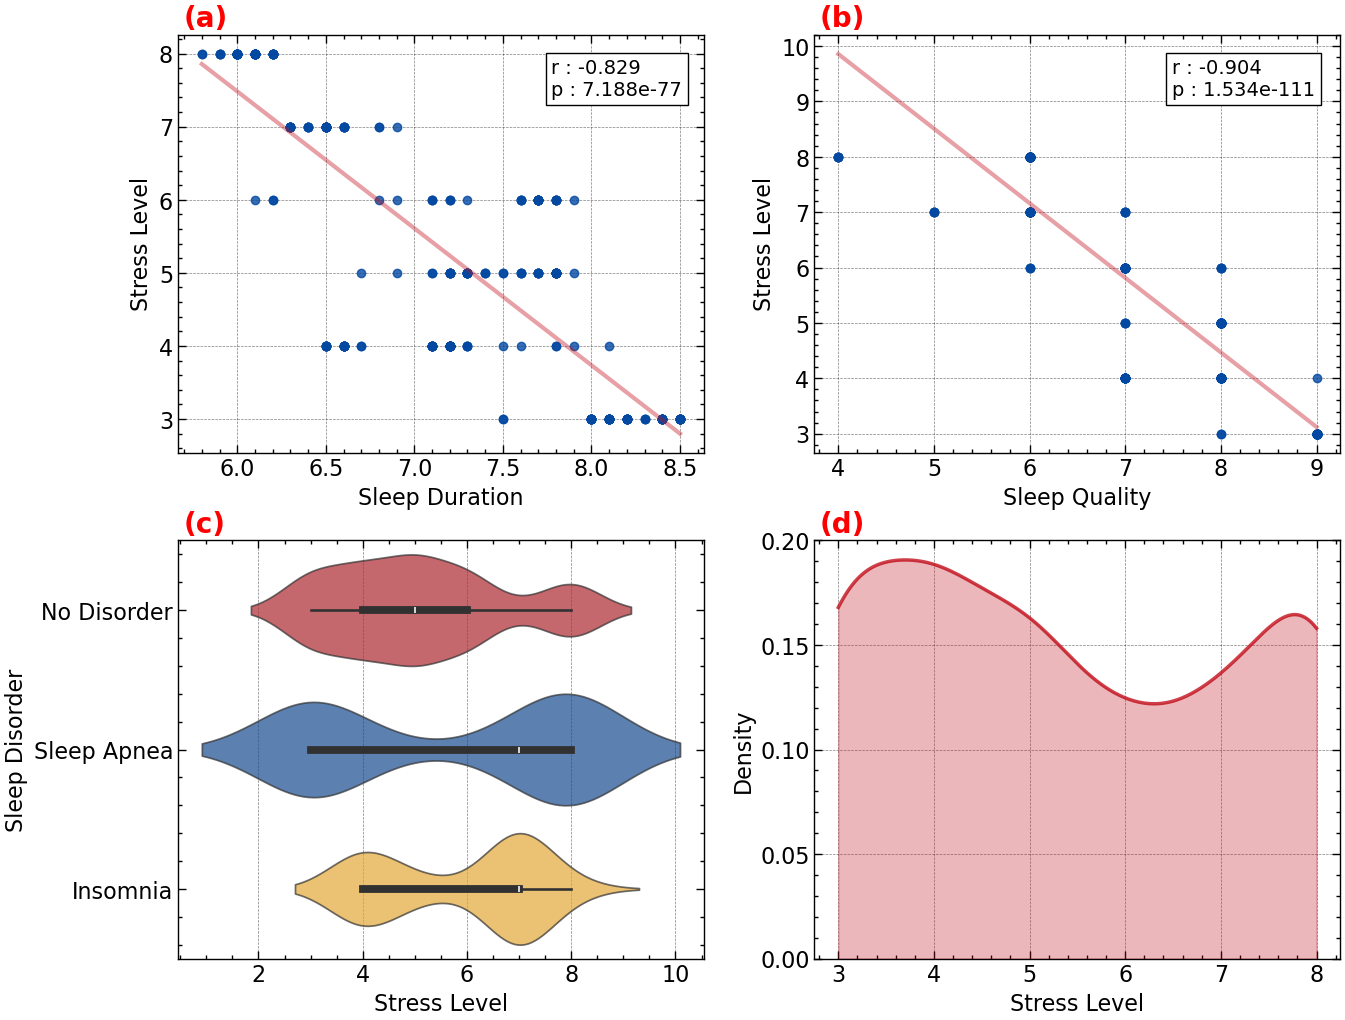

In [13]:
# ==========================================================
#               creating custom color pallet
# ==========================================================
seshadri = ['#c3121e', '#0348a1', '#ffb01c', '#027608',
            '#0193b0', '#9c5300', '#949c01', '#7104b5']
#            0sangre,   1neptune,  2pumpkin,  3clover,   
#            4denim,    5cocoa,    6cumin,    7berry


# setting up the plot grid
fig = plt.figure(figsize=(15, 12), dpi=100)
gs = gridspec.GridSpec(2, 2, figure=fig)
gs.update(wspace=0.21, hspace=0.21)

# ==========================================================
# PLOT 1
ax = fig.add_subplot(gs[0])
lr = linregress(y=train_df['sleep_duration'], x=train_df['stress_level'])
sns.regplot(
    data=train_df,
    x='sleep_duration',
    y='stress_level',
    ci=False,
    line_kws=dict(color=seshadri[0], alpha=0.4),
    scatter_kws=dict(color=seshadri[1])
)

# print r and p value
ax.text(
    0.71, 0.855,
    f'r : {lr.rvalue:.3f} \np : {lr.pvalue:.3e}',
    fontsize=14,
    transform=ax.transAxes,
    bbox=dict(facecolor='white', edgecolor='black')
)

# print figure label
ax.text(
    0.01, 1.02,
    '(a)',
    color='red',
    fontsize=20,
    fontweight='bold',
    transform=ax.transAxes
)

ax.set_xlabel('Sleep Duration')
ax.set_ylabel('Stress Level')

# ==========================================================
# PLOT 2
ax = fig.add_subplot(gs[1])
lr = linregress(y=train_df['sleep_quality'], x=train_df['stress_level'])
sns.regplot(
    data=train_df,
    x='sleep_quality',
    y='stress_level',
    ci=False,
    line_kws=dict(color=seshadri[0], alpha=0.4),
    scatter_kws=dict(color=seshadri[1])
)

# print r and p value
ax.text(
    0.68, 0.855,
    f'r : {lr.rvalue:.3f} \np : {lr.pvalue:.3e}',
    fontsize=14,
    transform=ax.transAxes,
    bbox=dict(facecolor='white', edgecolor='black')
)

# print figure label
ax.text(
    0.01, 1.02,
    '(b)',
    color='red',
    fontsize=20,
    fontweight='bold',
    transform=ax.transAxes
)

ax.set_xlabel('Sleep Quality')
ax.set_ylabel('Stress Level')

# ==========================================================
# PLOT 3
ax = fig.add_subplot(gs[2])

sns.violinplot(
    data=train_df,
    y='sleep_disorder',
    x='stress_level',
    hue='sleep_disorder',
    palette=seshadri,
    alpha=0.7,
    ax=ax
)

# print figure label
ax.text(
    0.01, 1.02,
    '(c)',
    color='red',
    fontsize=20,
    fontweight='bold',
    transform=ax.transAxes
)

ax.set_ylabel('Sleep Disorder')
ax.set_xlabel('Stress Level')

# ==========================================================
# PLOT 4
ax = fig.add_subplot(gs[3])

kde = gaussian_kde(train_df['stress_level'])
x_range = np.linspace(train_df['stress_level'].min(),
                      train_df['stress_level'].max(), 200)
y_kde = kde(x_range)

ax.plot(
    x_range,
    y_kde,
    color=seshadri[0],
    linewidth=2.5,
    alpha=0.8
)
ax.fill_between(x_range, y_kde, alpha=0.3, color=seshadri[0])
ax.set_xlabel('Stress Level')
ax.set_ylabel('Density')
ax.set_yticks(np.arange(0, 0.21, 0.05))
ax.set_ylim(0, 0.20)

# print figure label
ax.text(
    0.01, 1.02,
    '(d)',
    color='red',
    fontsize=20,
    fontweight='bold',
    transform=ax.transAxes
)

plt.show()

**Figure 1:** Exploratory data analysis of sleep features and stress levels

#### (a) Sleep Duration vs Stress
There's a strong negative correlation (r = -0.829, p = 7.188e-77), indicating that longer sleep duration is significantly associated with lower stress levels. This relationship is highly statistically significant.

#### (b) Quality of Sleep vs Stress
An even stronger negative correlation exists (r = -0.904, p = 1.534e-111), suggesting that better sleep quality has a more pronounced relationship with reduced stress than sleep duration alone. The extremely low p-value confirms this is not due to chance.

#### (c) Sleep Disorders and Stress Distribution
The violin plots reveal that individuals with no sleep disorder cluster at higher stress levels (centered around 5-6), while those with sleep apnea and insomnia show broader distributions with generally elevated stress. Insomnia cases appear to have slightly higher median stress levels than sleep apnea.

#### (d) Overall Stress Distribution
The bimodal density plot suggests two distinct subpopulations in the dataset - one centered around stress level 4 and another around stress level 7-8. This could indicate fundamentally different groups, possibly corresponding to those with and without sleep-related issues.

#### Overall Summary and Future Directions
The data strongly supports that both sleep quantity and quality are inversely related to stress, with sleep quality being the stronger predictor of stress levels. Given the clear linear trends observed in the data, implementing a Linear Regression model such as Ridge Regression would be an optimal approach to quantify how well these sleep-related features can explain variations in stress levels.

In [14]:
# Validate training data for anomalous correlations:
# - between the target (Sleep Disorder) and the features
# - between the features themselves
# These checks are run on the TRAIN split as part of EDA to make sure
# there are no suspiciously strong relationships that could indicate
# data leakage, data errors, or redundant features before we fit models.

df_train = train_df.copy()
# df_train["sleep_disorder"] = train_df["sleep_disorder"]

sleep_train_ds = Dataset(df_train, label="sleep_disorder", cat_features=[])

check_feat_lab_corr = FeatureLabelCorrelation().add_condition_feature_pps_less_than(0.9)
check_feat_lab_corr_result = check_feat_lab_corr.run(dataset=sleep_train_ds)

check_feat_feat_corr = FeatureFeatureCorrelation().add_condition_max_number_of_pairs_above_threshold(
    threshold=0.92,
    n_pairs=0
)
check_feat_feat_corr_result = check_feat_feat_corr.run(dataset=sleep_train_ds)

if not check_feat_lab_corr_result.passed_conditions():
    raise ValueError("Feature–label correlation exceeds the maximum acceptable threshold.")

if not check_feat_feat_corr_result.passed_conditions():
    raise ValueError("Feature–feature correlation exceeds the maximum acceptable threshold.")

### 4.3 Baseline Model

We separate the feature columns and the target column. 

In [15]:
X_train = train_df.drop(columns=["stress_level"])
y_train = train_df["stress_level"]
X_test = test_df.drop(columns=["stress_level"])
y_test = test_df["stress_level"]

We train a `DummyClassifier` as our baseline model. 

In [16]:
dummy = DummyClassifier()

dummy_scores = cross_validate(
    dummy,
    X_train,
    y_train,
    cv=5,
    return_train_score=True
)

dummy_df = pd.DataFrame(dummy_scores)
dummy_df

,fit_time,score_time,test_score,train_score
0,0.001910,0.002090,0.20000,0.200837
1,0.002878,0.001013,0.20000,0.200837
2,0.001100,0.000000,0.20000,0.200837
3,0.001096,0.001279,0.20000,0.200837
4,0.001019,0.000993,0.20339,0.200000


Our baseline model shows a validation accuracy of around 20%. We therefore aim for a test score higher than that. 

### 4.4 Column Transformation

We will perform standard scaling on `Sleep Duration` and one-hot encoding on `Sleep Disorder`. `Quality of Sleep` contains naturally ordered integers and therefore does not require transformation. 

We set up a `ColumnTransformer` to use in the pipeline.  

In [17]:
preprocesser = make_column_transformer(
    (StandardScaler(), ["sleep_duration"]),
    (OneHotEncoder(), ["sleep_disorder"]),
)

preprocesser

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['sleep_duration']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['sleep_disorder'])])

### 4.5. Training and Validation

In [18]:
ridge_pipe = make_pipeline(
    preprocesser,
    Ridge(alpha=1.0)
)

cv_results = cross_validate(
    ridge_pipe,
    X_train,
    y_train,
    cv=5,
    scoring=['neg_mean_squared_error', 'r2'],
    return_train_score=True
)

cv_results_df = pd.DataFrame(cv_results).rename(columns={
    'test_neg_mean_squared_error': 'test_neg_MSE',
    'train_neg_mean_squared_error': 'train_neg_MSE'
})
cv_results_df

,fit_time,score_time,test_neg_MSE,train_neg_MSE,test_r2,train_r2
0,0.025191,0.008265,-0.966525,-0.939745,0.735982,0.702552
1,0.022778,0.021332,-1.115303,-0.901239,0.600846,0.733666
2,0.020955,0.009718,-0.941442,-0.952310,0.693674,0.712694
3,0.013077,0.008208,-0.769661,-0.989587,0.789710,0.688111
4,0.011973,0.006069,-1.068692,-0.914836,0.641952,0.726779


The linear regression model demonstrated strong generalization with a mean cross-validated score of 0.69, closely matching the mean training score of 0.71. This indicates that the three selected features robustly explain approximately 70% of the variance in the target variable with minimal overfitting.

### 4.6. Model Evaluation

The linear regression model explains approximately **52%** of the variance in stress levels ($R^2 \approx 0.52$). Given that stress levels range from 3 to 8 (range = 5), the RMSE between 1.2 to 1.3 represents approximately **25%** of this range, indicating moderate prediction accuracy.

In [19]:
ridge_pipe.fit(X_train, y_train)
y_pred = ridge_pipe.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R^2: {r2:.4f}")

MSE: 1.2503
R^2: 0.5171


Finally, we visualize the prediction results.

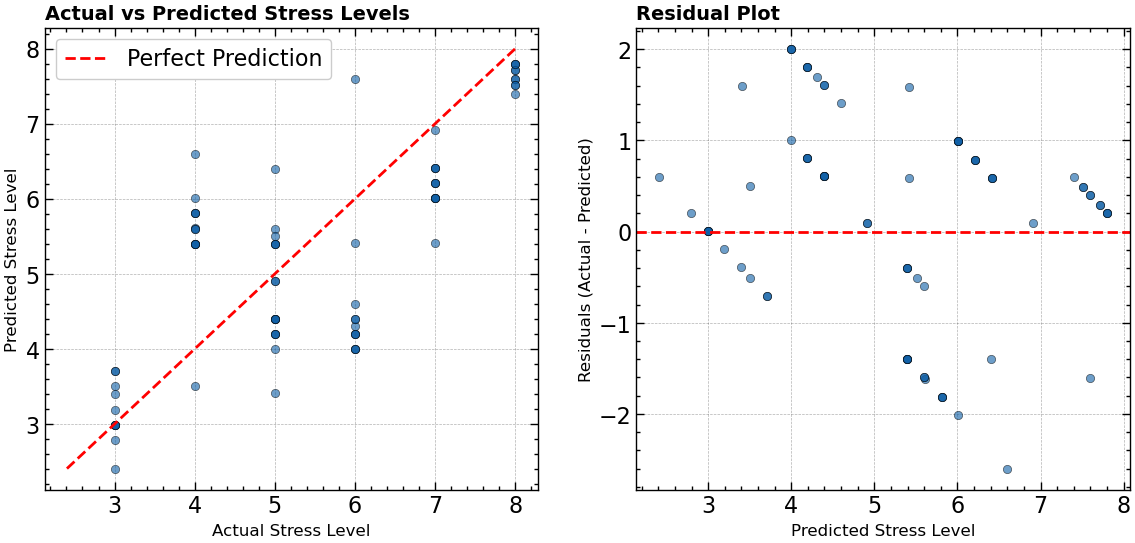

In [20]:
# Calculate residuals
residuals = y_test - y_pred

# Create figure with GridSpec
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, figure=fig, wspace=0.2)

# ==========================================================
# PLOT 1: Actual vs Predicted
# prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

ax = fig.add_subplot(gs[0])
ax.scatter(
    y_test,
    y_pred,
    alpha=0.6,
    edgecolors='k',
    linewidth=0.5
)
ax.plot(
    [min_val, max_val],
    [min_val, max_val],
    'r--',
    lw=2,
    label='Perfect Prediction'
)

ax.set_xlabel('Actual Stress Level', fontsize=12)
ax.set_ylabel('Predicted Stress Level', fontsize=12)
ax.set_title(
    'Actual vs Predicted Stress Levels',
    fontsize=14, fontweight='bold', loc='left'
)
ax.legend()
ax.grid(True, alpha=0.3)

# ==========================================================
# PLOT 2: Residuals
ax = fig.add_subplot(gs[1])
ax.scatter(
    y_pred,
    residuals,
    alpha=0.6,
    edgecolors='k',
    linewidth=0.5
)
ax.axhline(y=0, color='r', linestyle='--', lw=2)

ax.set_xlabel('Predicted Stress Level', fontsize=12)
ax.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
ax.set_title('Residual Plot', fontsize=14, fontweight='bold', loc='left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Figure 2:** Ridge regression model performance evaluation on test data

#### Interpretation of the Plots
The actual vs predicted plot shows moderate predictive performance with reasonable alignment along the diagonal line, though there's notable scatter indicating imperfect predictions, particularly for mid-range stress levels (4-6). The residual plot shows a slight negative trend, suggesting the model tends to overpredict at lower stress levels and underpredict at higher stress levels, indicating potential non-linear relationships in the data.

## 5. Discussion

### 5.1. Summary of Findings

The analysis revealed strong negative correlations between sleep duration, sleep quality, and stress levels, with sleep quality being the most significant predictor. The linear regression model explained approximately 52% of the variance in stress levels, indicating that these sleep-related features are meaningful but not exhaustive predictors of stress.

### 5.2. Expected vs Actual Outcomes

The findings aligned with our expectations that better sleep patterns would correlate with lower stress levels. However, the model's moderate predictive accuracy suggests that while sleep is a crucial factor, other variables likely contribute significantly to stress. This highlights the complexity of stress as a multifaceted phenomenon influenced by various lifestyle, psychological, and environmental factors.

### 5.3. Assumptions and Limitations

To predict stress levels from our features, we employed Ridge regression, which implicitly assumes a linear relationship between the predictors and the target variable. This linearity assumption represents a key limitation, as real-world relationships between sleep parameters, lifestyle factors, and perceived stress are often non-linear (as suggested by some of our EDA scatter plots).
Additionally, we did not incorporate polynomial or interaction terms, further restricting the model’s ability to capture more complex patterns.
Another important limitation arises from the presence of outliers observed in the exploratory data analysis. Because mean squared error (MSE) is highly sensitive to outliers and is reported on a squared scale (making interpretation less intuitive), it may not have been the most robust evaluation metric. Similarly, $R^2$ assumes linearity and can be misleading when the true relationship is non-linear. 

### 5.4. Impact and Applications

Understanding the relationship between sleep and stress has important implications for public health. Interventions aimed at improving sleep quality and duration could be effective strategies for stress reduction. There is however a lingering question of which direction the causality goes—does poor sleep lead to higher stress, or does high stress lead to poor sleep? Future studies could explore this bidirectional relationship further.

### 5.5. Future Work

Future research could establish the correct direction of causality between sleep and stress through longitudinal or experimental studies. Additionally, incorporating more comprehensive lifestyle, psychological, and physiological variables (e.g., actigraphy data, cortisol measurements, or validated anxiety/depression scales) could substantially enhance the predictive power of stress-assessment models. Exploring non-linear modeling techniques (e.g., random forests, gradient boosting, or neural networks) and polynomial/interaction terms would better capture the complex relationships evident in the data. Finally, adopting more robust and interpretable evaluation metrics—such as mean absolute error (MAE), Huber loss, or median absolute error—would reduce the influence of outliers and provide clearer insights into model performance.

## 6. References

Centers for Disease Control and Prevention. (2024). *FastStats: Sleep in adults*. https://www.cdc.gov/sleep/data-research/facts-stats/adults-sleep-facts-and-stats.html

Husn, M. (2023). *Sleep health and lifestyle* [Data set]. GitHub. https://raw.githubusercontent.com/Muhanad-husn/Sleep-Health-and-Lifestyle/main/data.csv

Sleep Foundation. (2025). 100+ sleep statistics – Facts and data about sleep 2024. https://www.sleepfoundation.org/how-sleep-works/sleep-facts-statistics

Varishabatool. (n.d.). *Sleep health and lifestyle dataset* [Data set]. Kaggle. https://www.kaggle.com/datasets/varishabatool/disorder
